# Predicting flight cancellations - Classification Task
### Table of contents
#### Phase A - Data Preparation
1. Read the dataset and do minor pre-processing
2. Copy the dataset and dummy encode categorical variables
3. Do LOF on dummy dataset with 3 PCA components
4. Plug outliers on both datasets and clean them
5. Train-Test split on non-dummy dataset
6. Run SMOTE on X_train
7. Dummy encode again

#### Phase B - Model Building
1. Does departure time affect cancellations?
    * Using various classifiers, observe whether there are differences in including departure time as predictor.
    * Use the results to find the differences between different times of the day.
2. How different types of cancellations are affected by the weather?
    * Subset each cancellation type and run to the best model.
    * Build different models for cancellation types, compare coefficients.
    * Evaluate the effectiveness of the models on predicting each cancellation type.
3. Which aiports and time periods are more prone to cancellations?
    * Use season and origin as individual predictors.
    * Use the interaction of airport and season.
    * Compare to models without airport and season.

## <font color='red'>Note</font>
Due to the complexity of the methods used, the present classification analysis was ran on a 200.000 sample. To be able to run the grid search, cross-validation and the models on our personal computer, we had to make this decision in order to reduce the computing time.

In [ ]:
! pip install imblearn
! pip install pdpbox

In [1]:
def custom_cm(actual, predicted):
    cm = [[0,0],[0,0]]
    for i,j in zip(actual, predicted):
        cm[i][j]+=1
    return cm
def print_cm(cm):
    return "\t0\t1\n0\t{}\t{}\n1\t{}\t{}".format(cm[0][0],cm[0][1],cm[1][0],cm[1][1])

In [11]:
def run_model(clf, X_train, y_train, X_test, y_test, cols, importances = True, pdp = None):
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import cross_validate
    clf.fit(X_train[cols],y_train)
    preds=clf.predict(X_test[cols])
    #print(pd.crosstab(y_test,preds))
    scores = cross_validate(clf, X_train[cols],y_train, cv=10, scoring="roc_auc",n_jobs=8)
    print("Train score: ",scores["test_score"].mean())
    print("Test score: ",roc_auc_score(y_test,preds))
    if importances==True:
        importances = pd.DataFrame(clf.feature_importances_)
        importances = importances.set_index([cols])
        print(importances.sort_values(0, ascending=False))
    if pdp != None:
        plot_pdp(clf = clf, X_train = X_train, feat = pdp, columns = cols)
    return roc_auc_score(y_test,preds)

In [32]:
from pdpbox import pdp

In [33]:
def plot_pdp(clf, X_train, columns, feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(clf, X_train.sample(500), feature = feat, model_features=columns)
    return pdp.pdp_plot(p, "", plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters, plot_params = {'xticks_rotation': 90, 'title': "",
    'subtitle': ""})

## Phase A
### 1. 
* Read the dataset
* Bin month and departure time

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset = pd.read_csv("cleaned2.1.csv", index_col=0)
dataset.head()

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Month,TaxiOut,DayOfWeek,CancellationCode,CRSDepTime,CRSArrTime,CRSElapsedTime,UniqueCarrier,FlightNum,ArrDelay,...,SecurityDelay,LateAircraftDelay,Compet_daily,Compet_yearly,Avg_Delay_4hours,TaxiOut_y,DepDelay_y,Month_bins,DepTime_bins,DayOfMonthCategories
0,1,10.0,4,NaN,17.0,20.0,105.0,WN,230,15.0,...,0.0,11.0,18.484848,20.180886,10.953488,9.677966,32.025424,Winter,Afternoon,1
1,1,9.0,4,NaN,20.0,23.0,105.0,WN,361,32.0,...,0.0,21.0,18.484848,20.180886,22.777778,9.677966,32.025424,Winter,Evening,1
2,1,5.0,4,NaN,13.0,16.0,105.0,WN,397,11.0,...,NaN,NaN,18.484848,20.180886,8.921053,9.677966,32.025424,Winter,Afternoon,1
3,1,8.0,4,NaN,9.0,12.0,105.0,WN,3245,-7.0,...,NaN,NaN,18.484848,20.180886,3.000000,9.677966,32.025424,Winter,Morning,1
4,1,7.0,4,NaN,10.0,15.0,170.0,WN,304,-1.0,...,NaN,NaN,18.484848,20.180886,-0.282609,9.677966,32.025424,Winter,Morning,1


In [2]:
to_remove_clas = ["mslp", "vsby", 'ArrDelay','DepDelay',"Dest", "UniqueCarrier", 'CRSArrTime', 'FlightNum', "Avg_Delay_4hours","TaxiOut"]
dataset = dataset.drop(to_remove_clas, axis =1)

def bin_month(month):
    if month in [12,1,2]:
        return "Winter"
    elif month in [3,4,5]:
        return "Spring"
    elif month in [6,7,8]:
        return "Summer"
    else:
        return "Autumn"
    
dataset["Month_bins"] = dataset["Month"].map(bin_month)

def bin_deptime(time):
    if time in [4,5,6,7]:
        return "Early Morning"
    elif time in [8,9,10,11]:
        return "Morning"
    elif time in [12,13,14,15,16,17]:
        return "Afternoon"
    elif time in [18,19,20,21]:
        return "Evening"
    else:
        return "Night"

dataset["DepTime_bins"] = dataset.CRSDepTime.map(bin_deptime)
dataset = dataset.drop(['Month', 'DayOfWeek', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'DayOfMonthCategories',"CRSDepTime"], axis = 1)

dataset = dataset.sample(200000)

dataset = dataset[dataset.TaxiOut_y.isna()==False]
df_dummies = dataset.copy()

### 2.
* Encode categorical and scale numerical features


In [4]:
to_encode = ['Origin', "Month_bins", "DepTime_bins"]
df_dummies = pd.get_dummies(df_dummies, prefix_sep="_", columns=to_encode)

to_normalize = ['CRSElapsedTime','Distance','tmpf',"dwpf",'alti','sknt', 'Compet_daily', 'Compet_yearly', 'TaxiOut_y', 'DepDelay_y']
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

dataset[to_normalize] = scaler.fit_transform(dataset[to_normalize].values)
df_dummies[to_normalize] = scaler.fit_transform(df_dummies[to_normalize].values)

dataset = dataset[dataset.TaxiOut_y.isna() == False]
df_dummies = df_dummies[df_dummies.TaxiOut_y.isna() == False]

### 3. 
During the preprocessing we removed outliers that did not make sense in our data (e.g. Elapsed Time <0). For the next part we needed to remove outliers by taking into account the combination of all used features. So we decided to use the local outlier factor to do that. After trying different parameters, we found that 30 neighbours and 5% contamination gave us the best results while rerunning the algorithms, without also losing much data. 
Also, after experimenting with the algorithm, we found out that if gives better results on low dimension data. Thus, we decided to use the algorithm on PCA components instead of the original dataset. Actualy, this change gave us even better results, so we decided to use the algorithm this way. We also tried different number of used components, from 2 to 10, and found out that 3 was the best option.

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from pandas.plotting import scatter_matrix
import matplotlib.cm as cm
from random import randint

pca = PCA(3)
transformed = pca.fit_transform(df_dummies.drop("CancellationCode",axis=1))
transformed = pd.DataFrame(transformed)

In [6]:
from sklearn.neighbors import LocalOutlierFactor

loc= LocalOutlierFactor(n_neighbors = 30, contamination = 0.05)
outliers_loc = loc.fit_predict(transformed)

outliers_loc = pd.DataFrame(outliers_loc, index= dataset.index.values)
dataset['outlier'] = outliers_loc
dataset.groupby(["outlier","Cancelled"]).size()

outlier  Cancelled
-1       0              966
         1               34
 1       0            18438
         1              557
dtype: int64

### 4.
* Drop outliers

In [7]:
dataset = dataset[dataset.outlier == 1]
dataset = dataset.drop("outlier", axis=1)

In [8]:
df_dummies['outlier'] = outliers_loc
df_dummies = df_dummies[df_dummies.outlier == 1]
df_dummies = df_dummies.drop("outlier", axis=1)

### 5.
* Train-test split, 70% for training, 30% for testing

In [9]:
from sklearn.model_selection import train_test_split

y = dataset["Cancelled"]
x = dataset.drop("Cancelled", axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)


### 6.
We used SMOTE in order to balance the obseravations of the two classes. More specifically, we used SMOTENC which could also be applied on categorical features. SMOTE was proven very important for this analysis. The results amplified after using this technique.

In [10]:
from imblearn.over_sampling import SMOTENC
cat_cols = [1,11,12]
ros = SMOTENC(random_state=0, categorical_features = cat_cols)

X_train, y_train = ros.fit_resample(X_train.drop("CancellationCode", axis=1), y_train)
X_train= pd.DataFrame(X_train)
X_train.columns = x.drop("CancellationCode", axis=1).columns
y_train= pd.DataFrame(y_train)

### 7.
* Dummy encode categorical features again on the final dataset

In [27]:
to_encode = ['Origin', "Month_bins", "DepTime_bins"]
X_train = pd.get_dummies(X_train, prefix_sep="_", columns=to_encode)
X_test = pd.get_dummies(X_test, prefix_sep="_", columns=to_encode)

## Phase B

### Finding the best model
Before starting to tackle the research questions we would like to use the whole dataset and find the best model overall and get a grasp on which are the most important features. To do that we employed different algorithms and techniques.
* Used Random Forest, Gradient Boosting Machine, Adaptive Boost Classifier, Support Vector Classifier and Logistic Regression. 
* To evaluate the performance of the models we used the ROC_AUC score.
* 10 fold cross-validation was used for more robust results.
* We used Recursive Feature Elimination to get the top 10 features of each algorithm and reduce the complexity and, running time of the models.
* Then, using grid search, we pluged the best features to grid search to find the optimal parameters.

In [15]:
def run_rfe_and_score_best_feature(model, x_train, y_train, x_test, y_test):
    print('--------------------------------------------------------------')
    print("Running ",type(model).__name__)
    d = {"Model":type(model).__name__, "AUC_test":0, "AUC_cv":0, "Feature Importances":None, "Features":[]}
    selector = RFE(model, 10, step=1)
    selector = selector.fit(x_train,y_train)

    features = get_top_features(x_train, selector.ranking_)
    #print('features', features)
    model.fit(x_train[features],y_train)
    preds=model.predict(x_test[features])
    #print("AUC: ",roc_auc_score(y_test,preds))
    d["AUC_test"] = roc_auc_score(y_test,preds)
    
    from sklearn.model_selection import cross_validate
    scores = cross_validate(model, x_train[features],y_train, cv=10, scoring="roc_auc", n_jobs=8)
    d["AUC_cv"] = scores["test_score"].mean()
    
    importances = pd.DataFrame(model.feature_importances_)
    importances = importances.set_index([features])
    importances = importances.sort_values(0, ascending=False)
    d["Feature Importances"] = importances
    d["Features"] = features
    return d
        
def get_top_features(features, importances):
    zipped_and_sorted = sorted(zip(features, importances), key=lambda x: x[1])
    result = [x[0] for x in zipped_and_sorted if x[1] == 1]
    return result

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

gbm = GradientBoostingClassifier(random_state=0, n_estimators=10)
ada = AdaBoostClassifier(random_state=0, n_estimators=20)
rf = RandomForestClassifier(n_estimators=20)

best_models = {"rf":None, "gbm":None,"ada":None}
best_models["rf"] = run_rfe_and_score_best_feature(rf, X_train, y_train, X_test, y_test)
best_models["gbm"] = run_rfe_and_score_best_feature(gbm, X_train, y_train, X_test, y_test)
best_models["ada"] = run_rfe_and_score_best_feature(ada, X_train, y_train, X_test, y_test)

In [21]:
#As adviced from the RFE precess
rf_features = ['CRSElapsedTime','Distance','tmpf','dwpf','sknt','alti','Compet_daily','Compet_yearly','TaxiOut_y','DepDelay_y']
gbm_features = ['Distance','Compet_yearly','TaxiOut_y','DepDelay_y','Origin_BOS','Origin_DCA','Origin_DEN',
               'DepTime_bins_Afternoon','DepTime_bins_Early Morning','DepTime_bins_Morning']
ada_features = ['Distance','sknt','Compet_yearly','TaxiOut_y','DepDelay_y','Origin_DEN','Origin_RDU',
                'Month_bins_Autumn','DepTime_bins_Afternoon','DepTime_bins_Early Morning']

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "max_depth": [5,10,20,30,40],
    'n_estimators': [20,50, 100]
}
rf = RandomForestClassifier(class_weight={0:1,1:3})

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, verbose = 10)
grid_search.fit(X_train[best_models["rf"]["Features"]], y_train)
print(grid_search.best_params_)
#{'max_depth': 40, n_estimators: 100}

In [ ]:
param_grid = {
    'max_depth': [5, 10, 20],
    "learning_rate": [ 0.1, 0.2, 0.3, 0.4],
    'n_estimators': [20, 50, 100]
}

gbm = GradientBoostingClassifier()

grid_search_gbm = GridSearchCV(estimator = gbm, param_grid = param_grid,  n_jobs = -1, verbose = 10)
grid_search_gbm.fit(X_train[best_models["gbm"]["Features"]], y_train)
print(grid_search_gbm.best_params_)
#{'max_depth': 10, 'learning_rate': 0.4, n_estimators: 100}

In [ ]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [50, 100, 200]
}
ada = AdaBoostClassifier()

grid_search_ada = GridSearchCV(estimator = ada, param_grid = param_grid, n_jobs = -1, verbose = 10)
grid_search_ada.fit(X_train[best_models["ada"]["Features"]], y_train)
print(grid_search_ada.best_params_)
#{'learning_rate': 0.5, 'n_estimators': 200}

### Random Forest seems to overfit

Random forest seems to overfit on the training dataset, so we change the maximum depth of the trees. After trying different values, we found that 10 gives the best balance between train and test scores. We expect that train score is going to be higher since we have balanced classes and the most of the cancelled flights are artificial samples.

In [19]:
grid_search_rf_best_estimator_ = RandomForestClassifier(max_depth=10,n_estimators=100, n_jobs=8)
run_model(grid_search_rf_best_estimator_,X_train, y_train, X_test, y_test, rf_features, False)

col_0          0     1
Cancelled             
0          47754  7698
1            647   895
Train score:  0.9194003876227843
Test score:  0.7207961398802232


0.7207961398802232

In [13]:
grid_search_gbm_best_estimator_ = GradientBoostingClassifier(learning_rate=0.4, max_depth=10, n_estimators=100)
grid_search_rf_best_estimator_ = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
grid_search_ada_best_estimator_ = AdaBoostClassifier(learning_rate=0.5, n_estimators=200)

In [21]:
cols = ['CRSElapsedTime','Distance','tmpf',"dwpf",'alti','sknt', 'Compet_daily', 'Compet_yearly', 'TaxiOut_y', 'DepDelay_y']
X_train[cols] = X_train[cols].astype(float)
X_test[cols] = X_test[cols].astype(float)

In [22]:
from sklearn.linear_model import LogisticRegressionCV

logit = LogisticRegressionCV()
selector = RFE(logit, 10, step=1)
selector = selector.fit(X_train,y_train)

features = get_top_features(X_train, selector.ranking_)
logit.fit(X_train[features],y_train)
preds=logit.predict(X_test[features])
print("AUC: ",roc_auc_score(y_test,preds))

AUC:  0.6901980427704011


In [58]:
from sklearn.svm import SVC

columns = ['CRSElapsedTime','Distance', 'tmpf', 'dwpf', 'sknt','alti', 'Compet_daily', 'TaxiOut_y',"DepDelay_y"]
for kernel in [ "linear", "poly", 'rbf', "sigmoid"]:
    svc = SVC(kernel=kernel)
    svc.fit(X_train[columns],y_train)
    preds = svc.predict(X_test[columns])
    print(kernel,":", roc_auc_score(preds,y_test))

linear : 0.5404350476592186
poly : 0.5453412175189905
rbf : 0.5338009242238341
sigmoid : 0.5143354461449527


### Findings
* None of the Support Vector Classifier kernels produces good results for, thus, we are not using it for the rest of the analysis.
* The other algorithms have similar AUC scores with Logistic regression having the lower (0.69) and Random Forest the higher (0.72).
* Random Forest results amplified after changing the maximum depth from 40 to 10. It seemed that the model was overfitting on the training dataset. 
* The features 'Distance','Compet_yearly','TaxiOut_y','DepDelay_y', were found important for all the algorithms.
* After using SMOTE we observed improved predictions. Before using SMOTE, our classifiers were scoring around 0.50 AUC which is similar to a random model.

### 1. Does departure time affect cancellations?

To answer the research question we need to run different models using the categorical feature Departure time. Initially, the models were run on the categorical variable where each category represented one hour of the day (1-24). The results were not useful to determine whether there is a difference between different times of day. Thus, we binned DepTime into 5 categories, Early Morning, Morning, Afternoon, Evening and Night.
To evaluate whether there are differences between the categories, we run the models with and without the DepTime in order to find out if is really contributes to the predictions. Furthermore, to find the differences, we used the Logistic regression coefficients, the ensemble methods' feature importances and partial dependence plots.
Finaly, to evaluate the performance of different models we used the classification metric, AUC.

In [28]:
weather = ["alti","sknt","dwpf","tmpf"]
competition = ['Compet_daily']
other = ['CRSElapsedTime', 'Distance', 'TaxiOut_y', 'DepDelay_y']
originCols = [i for i in X_train.columns if "Origin" in i ]
monthbinsCols = ['Month_bins_Autumn', 'Month_bins_Spring', 'Month_bins_Summer','Month_bins_Winter']
depTimeBinsCols = ['DepTime_bins_Afternoon','DepTime_bins_Early Morning', 'DepTime_bins_Evening','DepTime_bins_Morning', 'DepTime_bins_Night']

We use logisistic regression using statsmodels in order to take advantage of the outputs. We use the top features found above plus the Departure time. Then, we use the same features to build a model using sklearn in order to use cross validation. In the following cells, we use the non-dummy dataset due to the way statsmodel.formula.api works.

In [26]:
from sklearn.model_selection import train_test_split

y = dataset["Cancelled"]
x = dataset.drop(["Cancelled","CancellationCode"], axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

Xtrain, ytrain = ros.fit_resample(Xtrain, ytrain)
Xtrain= pd.DataFrame(Xtrain)
Xtrain.columns = x.columns
ytrain= pd.DataFrame(ytrain)

train = Xtrain
train["Cancelled"] = ytrain
test = Xtest
test["Cancelled"] = ytest

In [27]:
numerical = ["CRSElapsedTime","Distance", "tmpf", "dwpf", "sknt","alti", "Compet_daily", "Compet_yearly", "TaxiOut_y", "DepDelay_y"]
train[numerical] = train[numerical].astype(float)
test[numerical] = test[numerical].astype(float)

In [28]:
#Without departure time bins
from statsmodels.formula.api import glm, logit
import statsmodels.api as sm
columns = ['CRSElapsedTime','Distance', 'tmpf', 'dwpf', 'sknt','alti', 'Compet_daily', 'TaxiOut_y',"DepDelay_y"]
formula = 'Cancelled ~ {}'.format("+".join(columns))

logreg = logit(formula=formula, data=train).fit()
print(logreg.summary())

#The predict() function can be used to generate predicted probabilities
prob1 = logreg.predict(test[columns])
roc_auc_score(test["Cancelled"],prob1)

Optimization terminated successfully.
         Current function value: 0.565948
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Cancelled   No. Observations:               258966
Model:                          Logit   Df Residuals:                   258956
Method:                           MLE   Df Model:                            9
Date:                Wed, 20 Nov 2019   Pseudo R-squ.:                  0.1835
Time:                        20:33:06   Log-Likelihood:            -1.4656e+05
converged:                       True   LL-Null:                   -1.7950e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4674      0.005    -96.625      0.000      -0.477      -0.458
CRSElapsedTime   

0.7772432951310715

In [29]:
# With departure time bins
from statsmodels.formula.api import glm, logit
import statsmodels.api as sm

columns = ['CRSElapsedTime','Distance', 'tmpf', 'dwpf', 'sknt','alti', 'Compet_daily', 'TaxiOut_y',"DepDelay_y"]
formula = 'Cancelled ~ {} + C(DepTime_bins)'.format("+".join(columns))

logreg = logit(formula=formula, data=train).fit()
print(logreg.summary())

#The predict() function can be used to generate predicted probabilities
prob1 = logreg.predict(test[columns+["DepTime_bins"]])
roc_auc_score(test["Cancelled"],prob1)

Optimization terminated successfully.
         Current function value: 0.551569
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Cancelled   No. Observations:               258966
Model:                          Logit   Df Residuals:                   258952
Method:                           MLE   Df Model:                           13
Date:                Wed, 20 Nov 2019   Pseudo R-squ.:                  0.2043
Time:                        20:33:18   Log-Likelihood:            -1.4284e+05
converged:                       True   LL-Null:                   -1.7950e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.0571      0.007     -8.22

0.7658289229280711

In [30]:
# Elapsed Time and sknt should be removed because of high p-value
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

columns = ['Distance', 'tmpf', 'dwpf','alti', 'Compet_daily', 'TaxiOut_y',"DepDelay_y"]
formula = 'Cancelled ~ {} + C(DepTime_bins)'.format("+".join(columns))

logreg = logit(formula=formula, data=train).fit()
print(logreg.summary())

#The predict() function can be used to generate predicted probabilities
prob1 = logreg.predict(test[columns+["DepTime_bins"]])
roc_auc_score(test["Cancelled"],prob1)

Optimization terminated successfully.
         Current function value: 0.552602
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Cancelled   No. Observations:               258966
Model:                          Logit   Df Residuals:                   258954
Method:                           MLE   Df Model:                           11
Date:                Wed, 20 Nov 2019   Pseudo R-squ.:                  0.2028
Time:                        20:33:23   Log-Likelihood:            -1.4311e+05
converged:                       True   LL-Null:                   -1.7950e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.0430      0.007     -6.26

0.7631634262476221

In [31]:
#Logistic Regression with cross-validation
features = ['Distance', 'tmpf', 'dwpf', 'sknt','alti', 'Compet_daily', 'TaxiOut_y',"DepDelay_y"]+depTimeBinsCols
logit = LogisticRegressionCV(cv=10)
logit.fit(X_train[features],y_train)
preds=logit.predict(X_test[features])
print("AUC: ",roc_auc_score(y_test,preds))

AUC:  0.7052828105830513


In [32]:
#Logistic Regression with cross-validation
features = ['Distance', 'tmpf', 'dwpf', 'sknt','alti', 'Compet_daily', 'TaxiOut_y',"DepDelay_y"]
logit = LogisticRegressionCV(cv=10)
logit.fit(X_train[features],y_train)
preds=logit.predict(X_test[features])
print("AUC: ",roc_auc_score(y_test,preds))

AUC:  0.7137950275500303


### Ensemble methods
* Then, we use the 3 ensemble algorithms, Random Forest, Gradient Boosting Machine and, Adaptive Boost Classifier. 
* We do not use Recursive Feature Elimination in order to see the differences between all the features.  
* We use 10 fold cross validation. 
* To interpret the model outcome, we plot the partial dependence plots of Depurture time and we also have a look on the feature importances.

In [33]:
# Without departure time bins
run_model(grid_search_rf_best_estimator_,X_train, y_train, X_test, y_test, [x for x in rf_features if x not in depTimeBinsCols], True)
run_model(grid_search_gbm_best_estimator_,X_train, y_train, X_test, y_test, [x for x in gbm_features if x not in depTimeBinsCols], True)
run_model(grid_search_ada_best_estimator_,X_train, y_train, X_test, y_test, [x for x in ada_features if x not in depTimeBinsCols], True)

col_0          0     1
Cancelled             
0          47651  7801
1            653   889
Train score:  0.9194596974678557
Test score:  0.7179218834335215
                       0
DepDelay_y      0.348822
TaxiOut_y       0.196351
sknt            0.089111
Distance        0.067597
Compet_yearly   0.062862
tmpf            0.055625
CRSElapsedTime  0.052912
Compet_daily    0.046147
alti            0.042510
dwpf            0.038062
col_0          0     1
Cancelled             
0          53974  1478
1           1248   294
Train score:  0.9911756455501151
Test score:  0.5820038980675543
                      0
DepDelay_y     0.325851
Distance       0.259025
Compet_yearly  0.256659
TaxiOut_y      0.121811
Origin_DEN     0.015691
Origin_BOS     0.010550
Origin_DCA     0.010412
col_0          0      1
Cancelled              
0          45167  10285
1            602    940
Train score:  0.8701567978327864
Test score:  0.7120610990091757
                       0
sknt               0.865
DepDelay

0.7120610990091757

col_0          0     1
Cancelled             
0          48133  7319
1            702   840
Train score:  0.9164956006523676
Test score:  0.7063795280160974
                                   0
DepDelay_y                  0.330591
TaxiOut_y                   0.165276
sknt                        0.071192
DepTime_bins_Afternoon      0.059501
Distance                    0.056760
tmpf                        0.054610
Compet_yearly               0.053254
alti                        0.045105
CRSElapsedTime              0.042024
Compet_daily                0.039546
dwpf                        0.033070
DepTime_bins_Morning        0.025088
DepTime_bins_Early Morning  0.013245
DepTime_bins_Evening        0.009247
DepTime_bins_Night          0.001489
col_0          0     1
Cancelled             
0          53919  1533
1           1202   340
Train score:  0.9916834532421392
Test score:  0.5964236675684877
                                   0
DepDelay_y                  0.317737
Compet_yearly       

0.7027857163106116

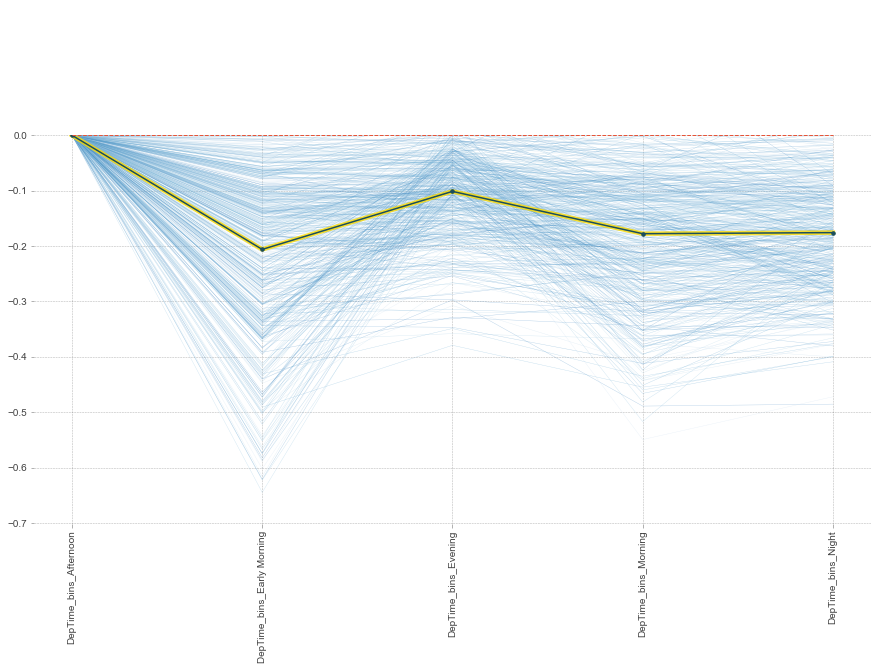

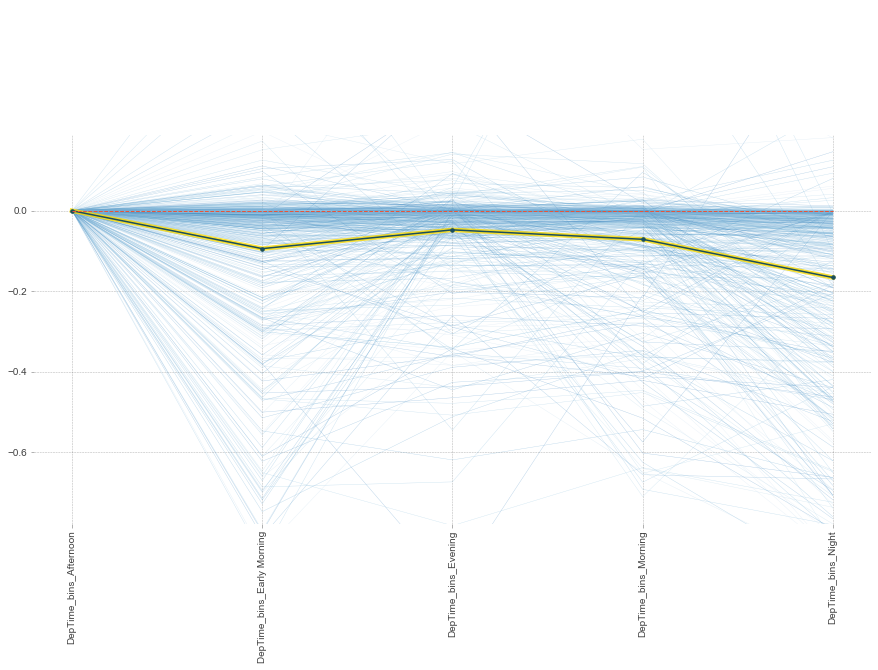

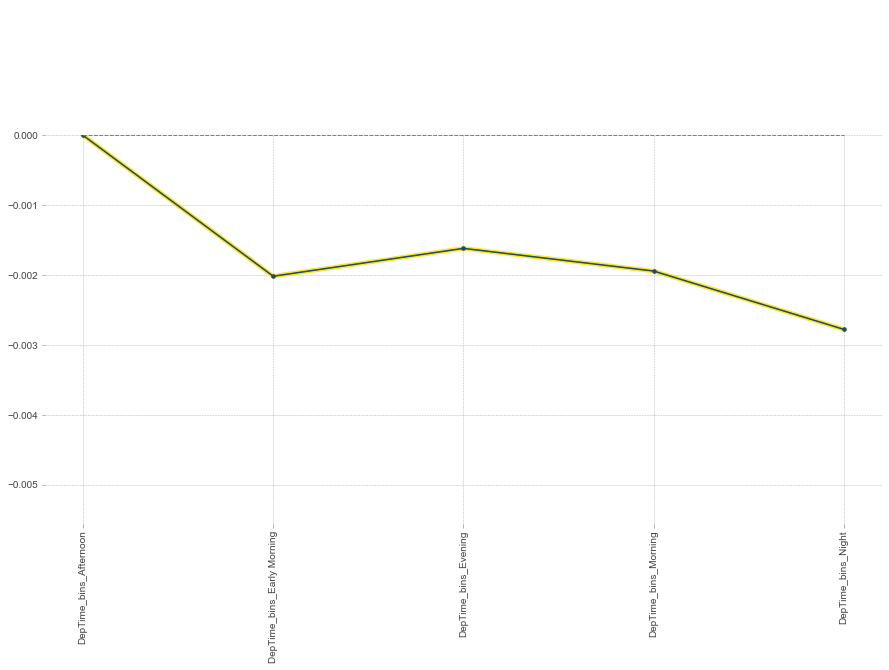

In [34]:
run_model(grid_search_rf_best_estimator_,X_train, y_train, X_test, y_test, list(set(rf_features+depTimeBinsCols)), True, depTimeBinsCols)
run_model(grid_search_gbm_best_estimator_,X_train, y_train, X_test, y_test, list(set(gbm_features+depTimeBinsCols)), True, depTimeBinsCols)
run_model(grid_search_ada_best_estimator_,X_train, y_train, X_test, y_test, list(set(ada_features+depTimeBinsCols)), True, depTimeBinsCols)

### Conclusions

* The  cross-validation scores are significantly higher than the test scores. This is expected since the test dataset has very few cancelled flights and even small changes make difference.
* In terms of ROC AUC, all the algorithms present similar results of around 0.70, except Gradient Boost which scores 0.58.
* Early morning and Night showed the strongest negative correlations, for all the algorithms, according to the Logistic regression coefficients and partial dependence plots.
* On the other hand, Afternoon seems to affect greatly the probability of a flight being cancelled. As we can see from the results, Aternoon is the base class after using dummy encoding. All the other time periods pull the prediction probability down.
* Comparing the algorithms with and without departure time, we found the it has a slight increase in Gradient Boost and slight decrease for the rest, but there is very little deviation in the results.
* Logistic regression with cross validation gives lower results that statsmodel.
* Based on the ensemble methods, the most important part of the day for the predictions is Afternoon.
* The feature importances provide crucial information for the features but using the partial dependency plots, we found how they affect the assigned probabilities.

## 2. How different types of cancellations are affected by the weather?
* Build different models for cancellation types, compare coefficients

First, we constructed a different training dataset for each cancellation code and run a different model using the weather on each one, again to test the capability of weather to predict each cancellation type. Also, using the second approach we can see how the dataset as a whole operates on each cancellation type.

In [35]:
#Prepare 3 different datasets, one for each cancellation type
dfNA = dataset[dataset.CancellationCode.isna()]
dfA = dataset[dataset.CancellationCode == "A"]
dfB = dataset[dataset.CancellationCode == "B"]
dfC = dataset[dataset.CancellationCode == "C"]
dfA = dfA.append(dfNA)
dfB = dfB.append(dfNA)
dfC = dfC.append(dfNA)

In [36]:
# Use SMOTE, train-test split and dummy encoding
def prepare_df(data):
    data = data.drop("CancellationCode", axis=1)
    from sklearn.model_selection import train_test_split
    y = data["Cancelled"]
    x = data.drop("Cancelled", axis=1)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    
    ros = SMOTENC(random_state=0, categorical_features = cat_cols, n_jobs=8)

    X_train, y_train = ros.fit_resample(X_train, y_train)
    X_train= pd.DataFrame(X_train)
    X_train.columns = x.columns
    y_train= pd.DataFrame(y_train)
    
    to_encode = ['Origin', "Month_bins", "DepTime_bins"]
    X_train = pd.get_dummies(X_train, prefix_sep="_", columns=to_encode)
    X_test = pd.get_dummies(X_test, prefix_sep="_", columns=to_encode)
    
    return X_train, X_test, y_train, y_test

aX_train, aX_test, ay_train, ay_test = prepare_df(dfA)
bX_train, bX_test, by_train, by_test = prepare_df(dfB)
cX_train, cX_test, cy_train, cy_test = prepare_df(dfC)

Create a Random Forest, GBM and AdaBoost model for each dataset.

In [54]:
res = {"A":{"rf":0,"gbm":0,"ada":0},"B":{"rf":0,"gbm":0,"ada":0},"C":{"rf":0,"gbm":0,"ada":0}}
clf = grid_search_rf_best_estimator_
res["A"]["rf"] = run_model(clf,aX_train, ay_train, aX_test, ay_test, list(set(rf_features+weather)), False)
res["B"]["rf"] = run_model(clf,bX_train, by_train, bX_test, by_test, list(set(rf_features+weather)), False)
res["C"]["rf"] = run_model(clf,cX_train, cy_train, cX_test, cy_test, list(set(rf_features+weather)), False)
clf = grid_search_gbm_best_estimator_
res["A"]["gbm"] = run_model(clf,aX_train, ay_train, aX_test, ay_test, list(set(gbm_features+weather)), False)
res["B"]["gbm"] = run_model(clf,bX_train, by_train, bX_test, by_test, list(set(gbm_features+weather)), False)
res["C"]["gbm"] = run_model(clf,cX_train, cy_train, cX_test, cy_test, list(set(gbm_features+weather)), False)
#Get the feature importances of the best estimator
clf = grid_search_ada_best_estimator_
res["A"]["ada"] = run_model(clf,aX_train, ay_train, aX_test, ay_test, list(set(ada_features+weather)), True)
res["B"]["ada"] = run_model(clf,bX_train, by_train, bX_test, by_test, list(set(ada_features+weather)), True)
res["C"]["ada"] = run_model(clf,cX_train, cy_train, cX_test, cy_test, list(set(ada_features+weather)), True)
res

col_0          0      1
Cancelled              
0          43223  12273
1            353    236
Train score:  0.8725813111348673
Test score:  0.5897640215982161
                                0
sknt                        0.815
Compet_yearly               0.045
Distance                    0.040
DepDelay_y                  0.030
DepTime_bins_Afternoon      0.015
Origin_RDU                  0.010
dwpf                        0.010
Month_bins_Autumn           0.010
Origin_DEN                  0.010
tmpf                        0.005
alti                        0.005
TaxiOut_y                   0.005
DepTime_bins_Early Morning  0.000
col_0          0     1
Cancelled             
0          47084  8422
1            163   334
Train score:  0.9066135547874768
Test score:  0.7601504243998927
                                0
sknt                        0.705
Compet_yearly               0.100
tmpf                        0.040
Distance                    0.035
DepDelay_y                  0.035
Ta

{'A': {'rf': 0.619796945245507,
  'gbm': 0.5247841475535457,
  'ada': 0.5897640215982161},
 'B': {'rf': 0.7683685618195172,
  'gbm': 0.598765982556239,
  'ada': 0.7601504243998927},
 'C': {'rf': 0.7996929662891228,
  'gbm': 0.5926395683935394,
  'ada': 0.8055875527779639}}

Create a Logistic regression model for each cancellation type using statsmodel.

In [40]:
def run_statsmodel(X_train, y_train, X_test, y_test, cols):
    from sklearn.metrics import roc_auc_score
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    logreg = sm.Logit(y_train.astype(float),X_train[columns+["const"]].astype(float)).fit()
    print(logreg.summary())

    prob1 = logreg.predict(X_test[columns+["const"]])
    prob = [1 if i>0.5 else 0 for i in prob1]
    print(print_cm(custom_cm(y_test,pd.Series(prob))))
    print(roc_auc_score(y_test,pd.Series(prob)))
    
columns = weather+competition+other
run_statsmodel(aX_train, ay_train, aX_test, ay_test, columns)
run_statsmodel(bX_train, by_train, bX_test, by_test, columns)
run_statsmodel(cX_train, cy_train, cX_test, cy_test, columns)

Optimization terminated successfully.
         Current function value: 0.652141
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      0   No. Observations:               258868
Model:                          Logit   Df Residuals:                   258858
Method:                           MLE   Df Model:                            9
Date:                Thu, 21 Nov 2019   Pseudo R-squ.:                 0.05916
Time:                        00:24:19   Log-Likelihood:            -1.6882e+05
converged:                       True   LL-Null:                   -1.7943e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
alti              -0.0950      0.005    -20.309      0.000      -0.104      -0.086
sknt             

### Conclusions

* We found that weather influenced models are capable of better predicting Weather and NAS cancellations but did poorly in predicting Carrier cancellations. This might mean that carrier cancellations are not affected by weather, and other reasons may explain this.
* We cannot find those reasons within the used dataset, because after training only on Carrier cancellations, the model still operates poorly. We assume that Carrier cancellations are more related to staffing and other airport operations which are not included in our data.
* Also, as we can see from the logistic regression coefficients, the weather weights for NAS and Weather Cancellations are greater than the ones of Carrier Cancellations. 

## 3. Which aiports and time periods are more prone to cancellations?
* Use season and origin as individual predictors.
* Use the interaction of airport and season.
* Compare to models without airport and season.

First we examined how the season and airport features affect the predictions. After we found some interesting results on the individual features, we decided to use interaction between the two features in order to dig deeper and find more useful results.

In [15]:
y = dataset["Cancelled"]
x = dataset.drop(["Cancelled","CancellationCode"], axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

Xtrain, ytrain = ros.fit_resample(Xtrain, ytrain)
Xtrain= pd.DataFrame(Xtrain)
Xtrain.columns = x.columns
ytrain= pd.DataFrame(ytrain)

train = Xtrain
train["Cancelled"] = ytrain
test = Xtest
test["Cancelled"] = ytest

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [42]:
from statsmodels.formula.api import logit,glm

columns = ['Distance', 'tmpf', 'dwpf', 'sknt','alti', 'Compet_daily', 'TaxiOut_y',"DepDelay_y"]
train[columns] = train[columns].astype(float)
formula = 'Cancelled ~ {} + C(Month_bins)+C(Origin)'.format("+".join(columns))

logreg = glm(formula=formula, data=train).fit()
preds=logreg.predict(test[columns+["Month_bins","Origin"]])
print("AUC: ",roc_auc_score(test["Cancelled"],preds))
print(logreg.summary())

AUC:  0.7650026086013917
                 Generalized Linear Model Regression Results                  
Dep. Variable:              Cancelled   No. Observations:               258916
Model:                            GLM   Df Residuals:                   258895
Model Family:                Gaussian   Df Model:                           20
Link Function:               identity   Scale:                         0.19096
Method:                          IRLS   Log-Likelihood:            -1.5304e+05
Date:                Thu, 21 Nov 2019   Deviance:                       49440.
Time:                        00:26:35   Pearson chi2:                 4.94e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
I

In [43]:
from statsmodels.formula.api import logit,glm

train[columns] = train[columns].astype(float)
columns = ['Distance', 'tmpf', 'dwpf', 'sknt','alti', 'Compet_daily', 'TaxiOut_y', "DepDelay_y"]
formula = 'Cancelled ~ {} + C(Month_bins)*C(Origin)'.format("+".join(columns))

logreg = glm(formula=formula, data=train).fit()
preds=logreg.predict(test[columns+["Month_bins","Origin"]])
print("AUC: ",roc_auc_score(test["Cancelled"],preds))
print(logreg.summary())

AUC:  0.7614249729095844
                 Generalized Linear Model Regression Results                  
Dep. Variable:              Cancelled   No. Observations:               258916
Model:                            GLM   Df Residuals:                   258868
Model Family:                Gaussian   Df Model:                           47
Link Function:               identity   Scale:                         0.18822
Method:                          IRLS   Log-Likelihood:            -1.5115e+05
Date:                Thu, 21 Nov 2019   Deviance:                       48725.
Time:                        00:26:40   Pearson chi2:                 4.87e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [16]:
#Create interaction column for origin and season
dataset["OriginSeason"] = dataset["Origin"] + "_" + dataset["Month_bins"]
dataset["OriginDepTime"] = dataset["Origin"] + "_" + dataset["DepTime_bins"]
dataset.head()

,CancellationCode,CRSElapsedTime,Origin,Distance,tmpf,dwpf,sknt,alti,Cancelled,Compet_daily,Compet_yearly,TaxiOut_y,DepDelay_y,Month_bins,DepTime_bins,OriginSeason,OriginDepTime
106477,NaN,0.885558,DFW,1.086267,-1.172558,-0.682684,-0.620228,1.799865,0,2.245193,2.305061,-0.275581,0.128065,Winter,Evening,DFW_Winter,DFW_Evening
1340464,NaN,-1.145724,DFW,-0.938510,1.654790,0.960708,1.531692,-0.012097,0,2.443680,2.305061,-0.643499,-0.436343,Autumn,Night,DFW_Autumn,DFW_Night
1362009,NaN,0.305191,LGA,-0.017517,0.798330,0.623864,-0.424599,-0.159012,0,-0.287338,-0.241157,1.741462,-0.529672,Autumn,Early Morning,LGA_Autumn,LGA_Early Morning
1102616,NaN,-0.623394,DEN,-0.667837,0.911837,0.909671,0.749176,0.036875,0,-1.257343,-1.236610,-0.015465,-0.470140,Summer,Morning,DEN_Summer,DEN_Morning
1151103,NaN,-0.492812,DEN,-0.432316,1.138850,-0.111070,1.140434,0.820426,0,0.492414,0.610319,-0.352979,-0.273999,Autumn,Evening,DEN_Autumn,DEN_Evening


In [17]:
d = dataset.copy()
y = d["Cancelled"]
x = d.drop(["Cancelled","CancellationCode"], axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

cat_cols = [1,11,12,13,14]
ros = SMOTENC(random_state=0, categorical_features = cat_cols, n_jobs=8)
Xtrain, ytrain = ros.fit_resample(Xtrain, ytrain)
Xtrain= pd.DataFrame(Xtrain)
Xtrain.columns = x.columns
ytrain= pd.DataFrame(ytrain)

In [18]:
#Label encode features
to_encode = ['Origin',"Month_bins", "DepTime_bins","OriginSeason","OriginDepTime"]
Xtrain = pd.get_dummies(Xtrain, prefix_sep="_", columns=to_encode)
Xtest = pd.get_dummies(Xtest, prefix_sep="_", columns=to_encode)

In [19]:
OriginSeasonCols = [i for i in Xtrain.columns if "OriginSeason" in i ]
OrigindepTimeCols = [i for i in Xtrain.columns if "OriginDepTime" in i ]

### Run Logistic regression with cross-validation for more robust results

In [51]:
#Logistic Regression with cross-validation
features = ['Distance', 'tmpf', 'dwpf', 'sknt','alti', 'Compet_daily', 'TaxiOut_y',"DepDelay_y"]+originCols+monthbinsCols
logit = LogisticRegressionCV(cv=10)
logit.fit(Xtrain[features],ytrain)
preds=logit.predict(Xtest[features])
print("AUC: ",roc_auc_score(ytest,preds))

features = ['Distance', 'tmpf', 'dwpf', 'sknt','alti', 'Compet_daily', 'TaxiOut_y',"DepDelay_y"]+OriginSeasonCols
logit = LogisticRegressionCV(cv=10)
logit.fit(Xtrain[features],ytrain)
preds=logit.predict(Xtest[features])
print("AUC: ",roc_auc_score(ytest,preds))

AUC:  0.716310417242368
AUC:  0.7137241139289875


### Run enseble methods with and without the interaction variable

In [30]:
run_model(grid_search_rf_best_estimator_,Xtrain, ytrain, Xtest, ytest, list(set(rf_features+originCols+monthbinsCols)), True)
run_model(grid_search_gbm_best_estimator_,Xtrain, ytrain, Xtest, ytest, list(set(gbm_features+originCols+monthbinsCols)), True)
run_model(grid_search_ada_best_estimator_,Xtrain, ytrain, Xtest, ytest, list(set(ada_features+originCols+monthbinsCols)), True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Train score:  0.9666320669642241
Test score:  0.653091438799604
                          0
DepDelay_y         0.193230
TaxiOut_y          0.140972
Origin_DEN         0.067867
Compet_yearly      0.067212
Distance           0.065487
sknt               0.064981
CRSElapsedTime     0.056712
Compet_daily       0.056389
Month_bins_Autumn  0.052454
alti               0.047224
tmpf               0.041520
dwpf               0.041051
Origin_ORD         0.024231
Month_bins_Spring  0.013863
Origin_LAX         0.012526
Month_bins_Winter  0.010623
Origin_SAN         0.008368
Origin_BOS         0.008024
Month_bins_Summer  0.007586
Origin_LGA         0.005418
Origin_DFW         0.005361
Origin_SJC         0.003514
Origin_RDU         0.002908
Origin_DCA         0.002477


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train score:  0.9940059615487306
Test score:  0.5539555140867122
                                   0
DepDelay_y                  0.262745
Compet_yearly               0.169738
Distance                    0.143645
TaxiOut_y                   0.126551
Origin_DEN                  0.054123
DepTime_bins_Afternoon      0.031865
DepTime_bins_Morning        0.026380
Month_bins_Spring           0.024922
Month_bins_Autumn           0.022245
Origin_LAX                  0.020760
Month_bins_Winter           0.017518
DepTime_bins_Early Morning  0.014919
Origin_ORD                  0.013449
Origin_SAN                  0.013340
Month_bins_Summer           0.012528
Origin_DFW                  0.008966
Origin_BOS                  0.008351
Origin_LGA                  0.008308
Origin_DCA                  0.007691
Origin_SJC                  0.006074
Origin_RDU                  0.005881


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train score:  0.9035146197742698
Test score:  0.6566110010917308
                                0
sknt                        0.635
Compet_yearly               0.140
Distance                    0.045
DepDelay_y                  0.040
TaxiOut_y                   0.025
Origin_DEN                  0.020
Month_bins_Autumn           0.015
DepTime_bins_Afternoon      0.015
DepTime_bins_Early Morning  0.010
Origin_DFW                  0.010
Origin_DCA                  0.010
Origin_RDU                  0.010
Origin_LAX                  0.010
Month_bins_Summer           0.005
Origin_BOS                  0.005
Origin_SAN                  0.005
Month_bins_Winter           0.000
Origin_SJC                  0.000
Month_bins_Spring           0.000
Origin_LGA                  0.000
Origin_ORD                  0.000


0.6566110010917308

Train score:  0.9671322226628851
Test score:  0.6409729098433493
                          0
DepDelay_y         0.215392
TaxiOut_y          0.119326
sknt               0.066762
Origin_DEN         0.065889
Distance           0.065392
Compet_yearly      0.064545
CRSElapsedTime     0.058124
Month_bins_Autumn  0.056634
Compet_daily       0.053613
alti               0.045082
tmpf               0.042318
dwpf               0.041039
Origin_ORD         0.022371
Origin_LAX         0.013847
Month_bins_Spring  0.011820
Month_bins_Summer  0.009429
Origin_SAN         0.009419
Month_bins_Winter  0.008726
Origin_BOS         0.008494
Origin_LGA         0.006936
Origin_DFW         0.005144
Origin_SJC         0.003695
Origin_RDU         0.003007
Origin_DCA         0.002997


0.6409729098433493

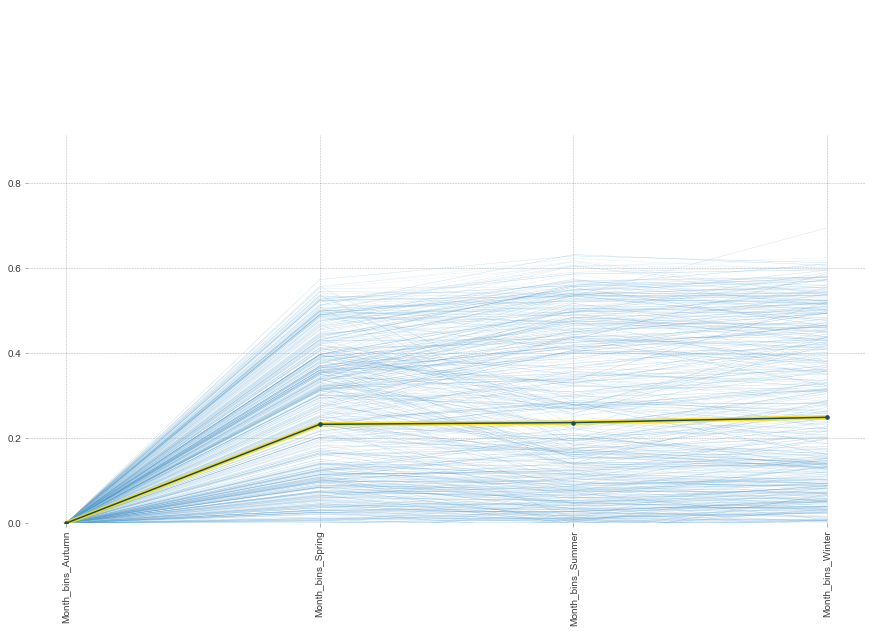

In [38]:
run_model(grid_search_rf_best_estimator_,Xtrain, ytrain, Xtest, ytest, list(set(rf_features+originCols+monthbinsCols)), True, monthbinsCols)

Train score:  0.9667892056128318
Test score:  0.6498961163158742
                          0
DepDelay_y         0.202179
TaxiOut_y          0.137627
Origin_DEN         0.068944
sknt               0.068364
Compet_yearly      0.065702
Distance           0.063646
CRSElapsedTime     0.057884
Compet_daily       0.055755
alti               0.045710
Month_bins_Autumn  0.044052
tmpf               0.042481
dwpf               0.040331
Origin_ORD         0.022058
Month_bins_Spring  0.014330
Origin_LAX         0.012835
Month_bins_Winter  0.011274
Origin_BOS         0.009245
Month_bins_Summer  0.009002
Origin_SAN         0.008222
Origin_LGA         0.006007
Origin_DFW         0.004574
Origin_SJC         0.003612
Origin_RDU         0.003169
Origin_DCA         0.002995


0.6498961163158742

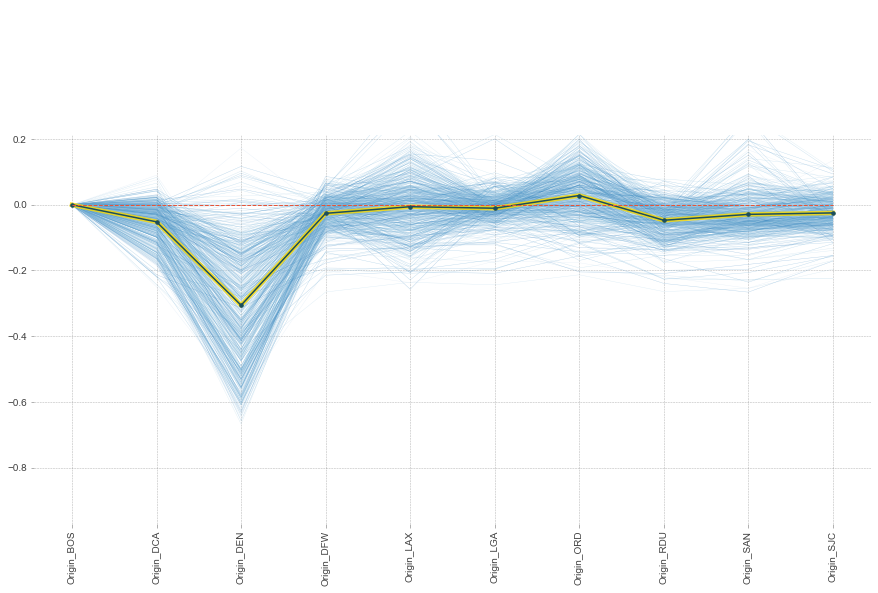

In [37]:
run_model(grid_search_rf_best_estimator_,Xtrain, ytrain, Xtest, ytest, list(set(rf_features+originCols+monthbinsCols)), True, originCols)

Train score:  0.9546546699698384
Test score:  0.6610493309975373
                                0
DepDelay_y               0.234608
TaxiOut_y                0.137572
Distance                 0.065401
sknt                     0.061101
Compet_yearly            0.053495
Compet_daily             0.051724
CRSElapsedTime           0.048685
OriginSeason_ORD_Winter  0.048377
alti                     0.046258
tmpf                     0.039223
dwpf                     0.037192
OriginSeason_DEN_Summer  0.019384
OriginSeason_ORD_Autumn  0.014709
OriginSeason_SAN_Winter  0.014278
OriginSeason_DFW_Spring  0.013002
OriginSeason_LAX_Spring  0.010394
OriginSeason_ORD_Spring  0.009639
OriginSeason_LGA_Summer  0.008706
OriginSeason_DFW_Autumn  0.008470
OriginSeason_BOS_Summer  0.007841
OriginSeason_DEN_Winter  0.007757
OriginSeason_DEN_Autumn  0.007567
OriginSeason_LGA_Autumn  0.007326
OriginSeason_LGA_Winter  0.006716
OriginSeason_DEN_Spring  0.005256
OriginSeason_ORD_Summer  0.004650
OriginSeason_DCA_

0.6446437487834396

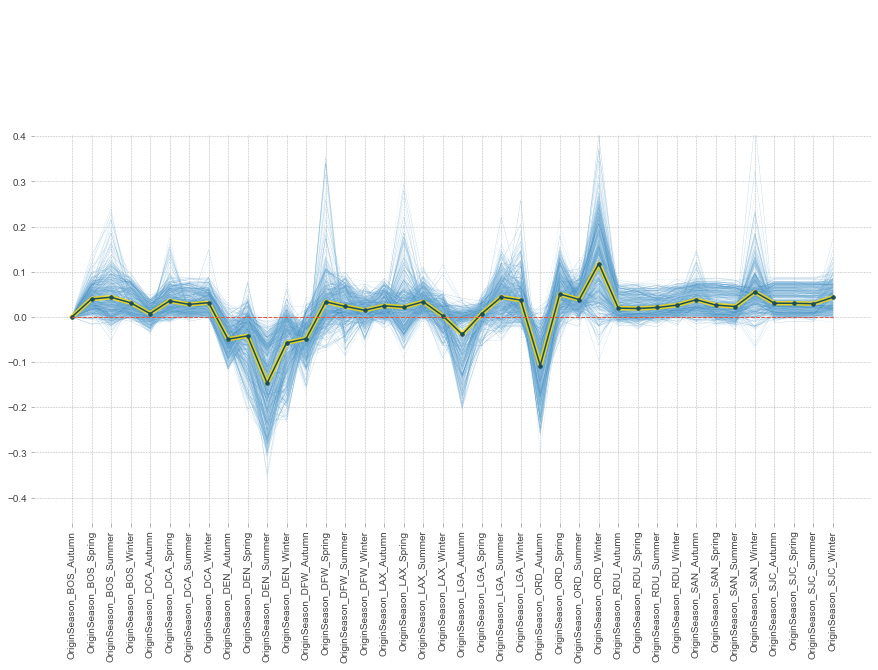

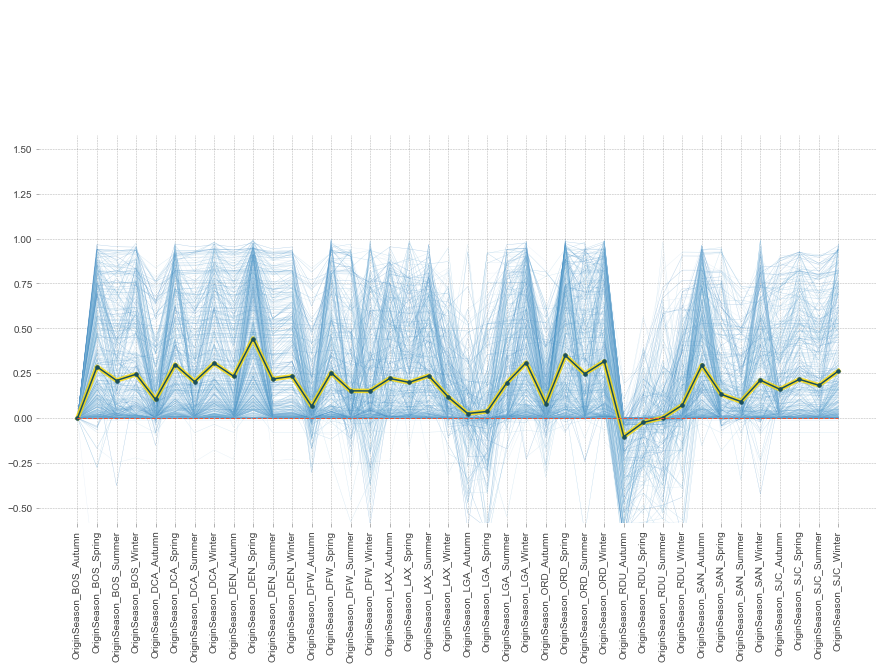

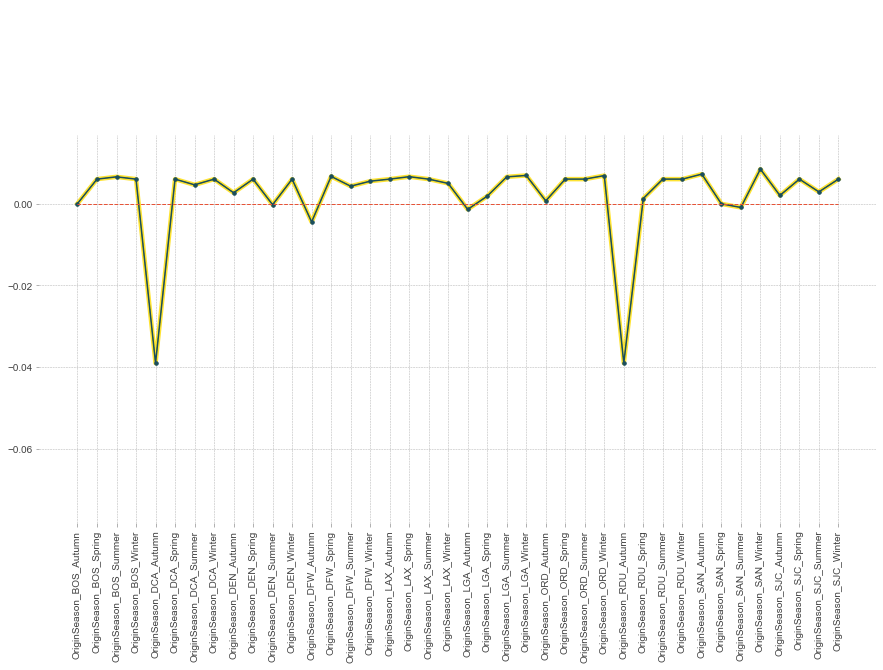

In [36]:
run_model(grid_search_rf_best_estimator_,Xtrain, ytrain, Xtest, ytest, list(set(rf_features+OriginSeasonCols)), True, OriginSeasonCols)
run_model(grid_search_gbm_best_estimator_,Xtrain, ytrain, Xtest, ytest, list(set(gbm_features+OriginSeasonCols)), True, OriginSeasonCols)
run_model(grid_search_ada_best_estimator_,Xtrain, ytrain, Xtest, ytest, list(set(ada_features+OriginSeasonCols)), True, OriginSeasonCols)

### Conclusions

* After using the interaction with airport and season, we had better results for our Random Forest and similar scores for Gradient Boost, AdaBoost and Logistic Regression.
* DCA was the only aiport with positive coefficient for the Logistic Regression. 
* Regarding the seasons, autumn was the only season with negative coefficients. 
* In search of more specific results, we used an interaction between the two features. 
* ORD in winter showed the higher effect on the predictions for Random Forest, while for the other algorithms is not clear. This is also confirmed by the Logistic Regression coefficients, as the pair ORD-winter has the higher weight among the interaction levels.
* Since, the results did not change for Gradient Boost and AdaBoost, we are using the outputs of Random Forest to make conclusions on the interaction.
* DEN had negative effect for the flight being cancelled, for all the seasons. It is also found important from the algorithms.